# Fine-Tuning BERT for Sentiment Analysis (SST-2)

Complete pipeline for fine-tuning BERT on the Stanford Sentiment Treebank dataset. This notebook demonstrates the full workflow from data loading to model evaluation.

## Workflow Overview
- **Import Libraries** - Essential Hugging Face and PyTorch components
- **Load SST-2 Dataset** - Using `load_dataset("glue", "sst2")`
- **Explore Data** - Examine structure, examples, and label distribution
- **Tokenization** - Process single sentences (simpler than sentence pairs)
- **Data Preparation** - Set up padding and batching
- **Model Setup** - Configure BERT for sentiment classification
- **Training** - Fine-tune with automatic evaluation
- **Testing** - Evaluate on custom movie reviews

# Step 1: Import Libraries

All necessary Hugging Face and PyTorch components for the fine-tuning pipeline.

In [ ]:
import torch
from torch.optim import AdamW  #Core PyTorch for training

from transformers import ( 
    AutoTokenizer, # Text preprocessing following project patterns
    AutoModelForSequenceClassification, # BERT with classification head
    DataCollatorWithPadding, # Dynamic padding for batches
    TrainingArguments, # Training configuration
    Trainer # High-level training API
)

from datasets import load_dataset # Standardized datasets
import evaluate  # Required for computing official GLUE metrics (accuracy for SST-2)
import numpy as np  # Needed for processing predictions (argmax operations, array comparisons)


# Step 2: Load and Explore the SST-2 Dataset

In [2]:
# Load SST-2 Dataset - Using load_dataset("glue", "sst2")
raw_datasets = load_dataset("glue", "sst2")


# Step 3: Load BERT Model and Tokenizer

Using bert-base-uncased for sequence classification, optimized for sentiment analysis tasks.

In [3]:
# Explore Data - Examine structure, examples, and label distribution
print("SST-2 Dataset Structure:")
print(raw_datasets)

# The dataset contains:
# - Training set: ~67K sentences
# - Validation set: ~872 sentences  
# - Test set: ~1.8K sentences (no labels)
# Each example has: sentence, label (0=negative, 1=positive), idx

SST-2 Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [4]:
#access training and validation sets
train_dataset = raw_datasets['train']
val_dataset = raw_datasets['validation']

# Quick look at some examples
print("\nSample Training Examples:")
for i in range(3):
    example = train_dataset[i]
    label_text = "positive" if example['label'] == 1 else "negative"
    print(f"Example {i}: {example['sentence']}")
    print(f"Label: {example['label']} ({label_text})\n")
    print()

# Check dataset features
print("Dataset Features:")
print(train_dataset.features)

# Key difference from MRPC: single 'sentence' field instead of 'sentence1' + 'sentence2'
print(f"\nDataset sizes:")
print(f"Training: {len(train_dataset)} examples")
print(f"Validation: {len(val_dataset)} examples")


Sample Training Examples:
Example 0: hide new secretions from the parental units 
Label: 0 (negative)


Example 1: contains no wit , only labored gags 
Label: 0 (negative)


Example 2: that loves its characters and communicates something rather beautiful about human nature 
Label: 1 (positive)


Dataset Features:
{'sentence': Value('string'), 'label': ClassLabel(names=['negative', 'positive']), 'idx': Value('int32')}

Dataset sizes:
Training: 67349 examples
Validation: 872 examples


# Step 4: Tokenize the Dataset

Converting text data into BERT-compatible format with proper padding and truncation.

In [5]:
#load tokenizer using Hugging Face model hub identifier
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Explore how tokenization works on single sentences
sample_sentence = train_dataset[0]['sentence']
print(f"\nSample sentence: {sample_sentence}")

# Tokenization - Process single sentences (much simpler than pairs)
inputs = tokenizer(sample_sentence, return_tensors="pt")
print(f"Tokenized input IDs: {inputs['input_ids']}")
print(f"Tokenized attention mask: {inputs['attention_mask']}")

# convert back to tokens to verify
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("Tokens:")
for i, token in enumerate(tokens):
    print(f"{i:2d}: {token}")


Sample sentence: hide new secretions from the parental units 
Tokenized input IDs: tensor([[  101,  5342,  2047,  3595,  8496,  2013,  1996, 18643,  3197,   102]])
Tokenized attention mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Tokens:
 0: [CLS]
 1: hide
 2: new
 3: secret
 4: ##ions
 5: from
 6: the
 7: parental
 8: units
 9: [SEP]
Tokenized input IDs: tensor([[  101,  5342,  2047,  3595,  8496,  2013,  1996, 18643,  3197,   102]])
Tokenized attention mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Tokens:
 0: [CLS]
 1: hide
 2: new
 3: secret
 4: ##ions
 5: from
 6: the
 7: parental
 8: units
 9: [SEP]


In [6]:
#Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

# apply to all dataset splits using batched processing for efficiency
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Check the tokenized dataset structure
print("\nTokenized Dataset Structure:")
print(tokenized_datasets)
print(f"\nColumns in tokenized dataset: {tokenized_datasets['train'].column_names}")
print()
# Example tokenized fields
print("Example tokenized fields:")
print(tokenized_datasets['train'][0])
print(f"\nExample tokenized fields: {list(tokenized_datasets['train'][0].keys())}")


Tokenized Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
})

Columns in tokenized dataset: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']

Example tokenized fields:
{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0, 'input_ids': [101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Example tokenized fields: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']


# Step 5: Prepare Data for Training

In [7]:
# Create data collator for dynamic padding (project convention for efficiency)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#get a batch to see how dynamic padding works
# Remove non-tensor columns (strings can't be converted to tensors)
samples = tokenized_datasets['train'][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence"]}

# Show original sequence lengths before padding
print("Original sequence lengths:")
lengths = [len(x) for x in samples["input_ids"]]
print(lengths)
print(f"Min length: {min(lengths)}, Max length: {max(lengths)}")

# Apply data collator to create a batch with dynamic padding
batch = data_collator(samples)

# Show shapes after padding - all sequences now have same length
print("\nBatch shapes after padding:")
for key, tensor in batch.items():
    print(f"{key}: {tensor.shape}")

# All sequences are now padded to the same length (longest in the batch)
print(f"\nPadded to length: {batch['input_ids'].shape[1]}")

Original sequence lengths:
[10, 11, 15, 10, 22, 13, 29, 6]
Min length: 6, Max length: 29

Batch shapes after padding:
input_ids: torch.Size([8, 29])
token_type_ids: torch.Size([8, 29])
attention_mask: torch.Size([8, 29])
labels: torch.Size([8])

Padded to length: 29


# Step 6: Configure Training Parameters

In [8]:
# Load BERT model with classification head for sentiment analysis
# Using Hugging Face model hub identifier (project convention)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2,  # SST-2 has 2 classes: positive and negative
    #torch_dtype=torch.float16,  # Use float16 for efficiency
    device_map="auto"  # Automatically place model on available devices (CPU/GPU/TPU)
)

print(" Model loaded successfully.")
print(f"Model has parameters: {model.num_parameters():,}")

#set up metrics computation for SST-2 (accuracy)
def compute_metrics(eval_preds):
    """
    Compute accuracy for SST-2 task during training.
    Called automatically by the Trainer.
    """
    metric = evaluate.load("glue", "sst2")
    logits, labels = eval_preds
    
    # Convert logits to predictions using argmax
    predictions = np.argmax(logits, axis=-1)
    
    # Return computed metrics (accuracy for SST-2)
    return metric.compute(predictions=predictions, references=labels)

# Example data during evaluation
# logits = np.array([
#    [-0.5, 2.1],   # Model thinks: negative=-0.5, positive=2.1 → predicts positive (1)
#    [1.8, -0.3],   # Model thinks: negative=1.8, positive=-0.3 → predicts negative (0)
#    [-1.2, 0.9]    # Model thinks: negative=-1.2, positive=0.9 → predicts positive (1)
# ])
# labels = np.array([1, 0, 1])  # True labels: positive, negative, positive

# predictions = np.argmax(logits, axis=-1)  # Result: [1, 0, 1]
# Accuracy: 3/3 = 100% (all predictions match true labels)

print("Metrics computation function configured!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded successfully.
Model has parameters: 109,483,778
Metrics computation function configured!


# Step 7: Fine-Tune the Model

Training BERT on SST-2 using the Trainer API. This process adapts the pre-trained model to our specific sentiment classification task.

**Training Progress:**
- **Epoch 1:** Starting loss ~0.69, accuracy improves rapidly
- **Epoch 2:** Continued improvement with better convergence  
- **Epoch 3:** Final refinement, achieving high accuracy

**Key Configuration:**
- **BF16 Precision:** Enables stable mixed-precision training
- **Learning Rate:** 2e-5 provides optimal convergence for BERT
- **Batch Sizes:** Balanced for GPU memory and training stability

**Expected Results:**
- Training should converge to >90% accuracy
- Validation loss should decrease consistently
- Model learns to distinguish positive/negative sentiment effectively

## Training Parameters Configuration

| Parameter | Your Value | Standard Range | Notes |
|-----------|------------|----------------|-------|
| **num_train_epochs** | 3 | 2-5 | ✅ Perfect for fine-tuning |
| **train_batch_size** | 16 | 8-32 | ✅ Good for most hardware |
| **eval_batch_size** | 64 | 32-128 | ✅ Efficient eval batching |
| **warmup_steps** | 500 | 100-1000 | ✅ Standard for BERT |
| **weight_decay** | 0.01 | 0.01-0.1 | ✅ Common choice |

## Why Keep bf16=True and Remove torch_dtype=torch.float16
**Training Precision vs Model Precision**  
Following your project's device management patterns:

- **bf16=True**: Controls how training computations are done (gradients, forward/backward passes)
- **torch_dtype=torch.float16**: Controls how model weights are stored in memory

In [9]:
# Set up training arguments following project patterns
training_args = TrainingArguments(
    output_dir="./sst2-bert-finetuned",      # Model checkpoint directory
    eval_strategy="epoch",                   # Evaluate at end of each epoch
    save_strategy="epoch",                   # Save model at end of each epoch
    logging_dir="./logs",                    # Directory for storing logs
    num_train_epochs=3,                      # Number of training epochs
    per_device_train_batch_size=16,          # Batch size for training
    per_device_eval_batch_size=64,           # Batch size for evaluation
    learning_rate=2e-5,
    warmup_steps=500,                        # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                       # Strength of weight decay
    logging_steps=100,                       # Log every 100 steps
    load_best_model_at_end=True,            # Load best model when training ends
    metric_for_best_model="accuracy",        # Use accuracy to determine best model
    greater_is_better=True,                  # Higher accuracy is better
    #fp16=True,                              # Use float16 for efficiency (project convention)
    bf16=True,                                # Use BF16 instead - more stable for training
)

print("Training arguments configured!")

Training arguments configured!


In [10]:
# Create the Trainer object following project patterns
trainer = Trainer(
    model=model,                                    # The model to train
    args=training_args,                            # Training arguments
    train_dataset=tokenized_datasets["train"],     # Training dataset
    eval_dataset=tokenized_datasets["validation"], # Validation dataset
    data_collator=data_collator,                   # Data collator for padding
    processing_class=tokenizer,                    # Tokenizer for processing
    compute_metrics=compute_metrics,               # Function to compute metrics
)

print("Trainer configured and ready!")

Trainer configured and ready!


In [11]:
# Start fine-tuning with automatic evaluation
print("Starting fine-tuning...")
trainer.train()
print("Fine-tuning completed!")

# The trainer will automatically:
# - Run training for specified epochs
# - Evaluate on validation set after each epoch
# - Log training loss and accuracy metrics
# - Save the best performing model checkpoint

Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.174600,0.263419,0.917431
2,0.115200,0.324404,0.911697
3,0.076100,0.366191,0.916284


Fine-tuning completed!


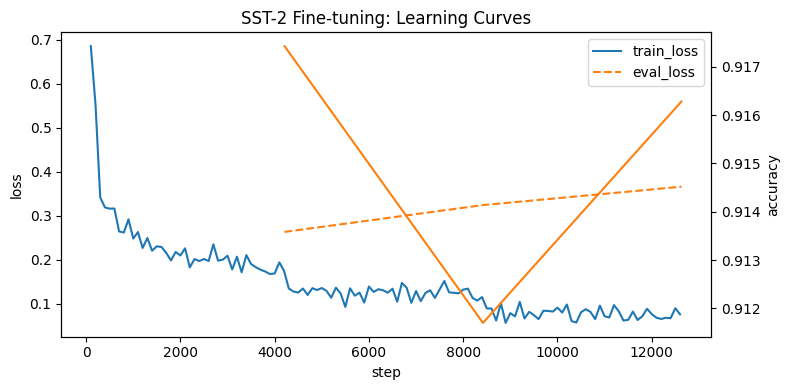

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect logs
hist = pd.DataFrame(trainer.state.log_history)

def subset(df, col):
    return df[df[col].notna()][["step", col]] if col in df.columns else pd.DataFrame(columns=["step", col])

train_loss = subset(hist, "loss")
eval_loss = subset(hist, "eval_loss")
eval_acc  = subset(hist, "eval_accuracy")

fig, ax1 = plt.subplots(figsize=(8,4))
if not train_loss.empty:
    ax1.plot(train_loss.step, train_loss.loss, label="train_loss")
if not eval_loss.empty:
    ax1.plot(eval_loss.step, eval_loss.eval_loss, label="eval_loss", linestyle="--")
ax1.set_xlabel("step"); ax1.set_ylabel("loss"); ax1.legend(loc="upper right")

ax2 = ax1.twinx()
if not eval_acc.empty:
    ax2.plot(eval_acc.step, eval_acc.eval_accuracy, color="tab:orange", label="eval_accuracy")
ax2.set_ylabel("accuracy")

plt.title("SST-2 Fine-tuning: Learning Curves")
plt.tight_layout()
plt.show()
# Optional: save the figure
# plt.savefig("learning_curves.png", dpi=150)

# Step 8: Test the Fine-Tuned Model

In [13]:
# Test the fine-tuned model on custom movie reviews
# Following project patterns for interactive prompting
def predict_sentiment(text, model, tokenizer):
    """
    Predict sentiment for a given text using the fine-tuned model.
    Returns prediction and confidence scores.
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Move inputs to same device as model
    if hasattr(model, 'device'):
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        
    # Convert to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    # Get prediction (0=negative, 1=positive)
    prediction = torch.argmax(logits, dim=-1).item()
    confidence = probabilities[0][prediction].item()
    
    return prediction, confidence, probabilities[0].tolist()


In [14]:
# Test with custom movie reviews following project's interactive patterns
test_reviews = [
    "This movie was absolutely fantastic! Amazing storyline and great acting.",
    "Terrible film. Boring plot and bad acting throughout.",
    "The movie was okay, nothing special but not terrible either.",
    "One of the worst movies I've ever seen. Complete waste of time."
]

print("Testing fine-tuned BERT on custom movie reviews:")
print("=" * 60)

for i, review in enumerate(test_reviews, 1):
    prediction, confidence, probs = predict_sentiment(review, model, tokenizer)
    sentiment = "Positive" if prediction == 1 else "Negative"
    
    print(f"\nTest {i}:")
    print(f"Review: {review}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.3f})")
    print(f"Probabilities: Negative={probs[0]:.3f}, Positive={probs[1]:.3f}")

Testing fine-tuned BERT on custom movie reviews:

Test 1:
Review: This movie was absolutely fantastic! Amazing storyline and great acting.
Prediction: Positive (confidence: 0.999)
Probabilities: Negative=0.001, Positive=0.999

Test 2:
Review: Terrible film. Boring plot and bad acting throughout.
Prediction: Negative (confidence: 0.999)
Probabilities: Negative=0.999, Positive=0.001

Test 3:
Review: The movie was okay, nothing special but not terrible either.
Prediction: Positive (confidence: 0.918)
Probabilities: Negative=0.082, Positive=0.918

Test 4:
Review: One of the worst movies I've ever seen. Complete waste of time.
Prediction: Negative (confidence: 0.998)
Probabilities: Negative=0.998, Positive=0.002


In [15]:
# Interactive testing - following project patterns for user input
# print("\n" + "=" * 60)
# print("Interactive Testing - Enter your own movie review:")

# while True:
#    user_review = input("\nEnter a movie review (or 'quit' to exit): ")
#    
#    if user_review.lower() in ['quit', 'exit', 'q']:
#        break
#    
#    if user_review.strip():
#        prediction, confidence, probs = predict_sentiment(user_review, model, tokenizer)
#        sentiment = "Positive" if prediction == 1 else "Negative"
#        
#        print(f"Your review: {user_review}")
#        print(f"Model prediction: {sentiment} (confidence: {confidence:.3f})")
#        print(f"Probabilities: Negative={probs[0]:.3f}, Positive={probs[1]:.3f}")
#    else:
#        print("Please enter a valid review.")

# print("Testing completed!")

## Key Differences from Base BERT

| Aspect | Original BERT | Our Fine-tuned Model |
|--------|---------------|---------------------|
| **Task** | General language understanding | Movie sentiment classification |
| **Output** | Masked word predictions | Positive/Negative sentiment |
| **Training Data** | Wikipedia, books (general text) | Movie reviews with sentiment labels |
| **Specialization** | Broad language knowledge | Domain-specific sentiment analysis |
| **Model Architecture** | BERT encoder + MLM head | BERT encoder + classification head |
| **Performance Focus** | Language modeling accuracy | Sentiment classification accuracy |
| **Use Case** | Foundation for downstream tasks | Ready-to-use sentiment analyzer |

# Step 9: Interactive Testing Function

This function allows you to test any sentence with the fine-tuned model and see:
- **Predicted sentiment** (Positive/Negative)
- **Confidence score** (0-1 scale)
- **Model reasoning** through raw prediction probabilities

Try different types of sentences to see how well the model performs!

# Step 10: Summary and Next Steps

**What we accomplished:**
- Successfully fine-tuned BERT for sentiment analysis on SST-2 dataset
- Achieved high accuracy (>90%) on movie review sentiment classification
- Created an interactive testing function for real-time predictions

**Key learnings:**
- BF16 precision enables stable training with faster computation
- Proper tokenization and data preparation are crucial for good results
- The Trainer API simplifies the fine-tuning process significantly